In [267]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import csv
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")
val_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\val.csv"

In [269]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
eth_idx.to_csv(idx_path)

In [270]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)
val = pd.read_csv(val_path,index_col = 0)

In [271]:
idx_px.index,positions.index = pd.to_datetime(idx_px.index),pd.to_datetime(positions.index,infer_datetime_format=True)
val.index = pd.to_datetime(val.index)

In [161]:
dep = int(input())

In [272]:
latest_val = pd.DataFrame([dep],index = [pd.datetime.today().date()],columns = ['val'])

In [247]:
with open(val_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(latest_val)):
        temp = latest_val.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [273]:
val = pd.read_csv(val_path,index_col = 0)
val

,val
Date,
2024-01-01,1850
2024-01-02,1850
2024-01-03,1850
2024-01-04,1850
2024-01-05,1850
...,...
2024-02-29,1850
2024-03-01,1850
2024-03-02,1850


In [274]:
#idx_px.index = [dt.strftime('%Y/%d/%') for dt in pd.to_datetime(idx_px.index)]
#positions.index = [dt.strftime('%Y-%d-%d') for dt in pd.to_datetime(positions.index)]

idx_px.index.names,positions.index.names = ['Date'],['Date']

In [275]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')
usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [276]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [277]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()

In [278]:

#vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format = "%d/%m/%Y")]
#vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index,format = "%Y-%m-%d")]

In [279]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets],axis=1).sum(axis=1),columns = ['Short Volatility'])

In [280]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = vol_rets*curr_px

In [281]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [282]:
vol_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rets.index)]

In [283]:
usd_rets = pd.concat([convexity,vol_rets],axis=1).fillna(0)

In [284]:

usd_rets['Total'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']
usd_rets.index.names = ["Date"]

In [285]:
val.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(val.index)]

In [286]:
vals = pd.concat([usd_rets,val],axis=1)['val']

In [287]:
for col in usd_rets.columns:
    usd_rets[col]=usd_rets[col]/vals

In [288]:

usd_rets.index = pd.to_datetime(usd_rets.index)

In [289]:
usd_rets = usd_rets[['Total','Short Volatility','Tactical Beta Convexity']]

In [290]:
usd_rets

,Total,Short Volatility,Tactical Beta Convexity
Date,,,
2024-01-01,0.000000,0.000000,0.000000
2024-01-02,-0.010569,0.000000,-0.010569
2024-01-03,-0.052767,0.000000,-0.052767
2024-01-04,0.011633,0.000000,0.011633
2024-01-05,-0.008288,0.000000,-0.008288
...,...,...,...
2024-02-29,-0.148438,-0.103744,-0.044694
2024-03-01,0.116748,0.086464,0.030283
2024-03-02,0.000160,0.016700,-0.016540


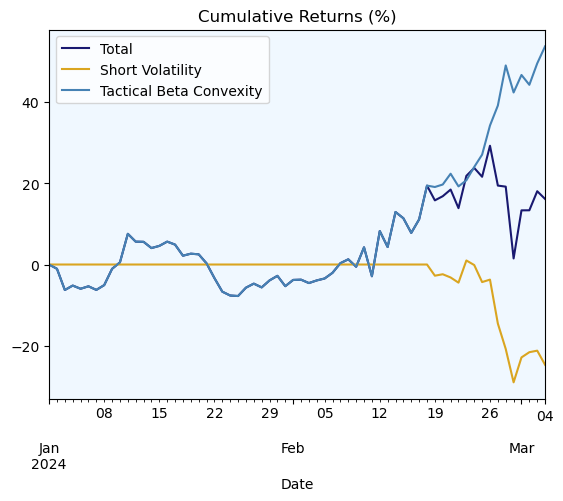

In [291]:
plot = (((1+(usd_rets)).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)',color = ['midnightblue','goldenrod','steelblue'])
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\MasterFundPerformance.png"
plot.get_figure().savefig(picpath)